## BusTime sample exploration of gaps in quasi-continuous vehicle data streams.
Ground-truth data sources (e.g. samples from MTA, DOT shown in the dot_sample_exploration.ipynb) indicate that the vehicles reliably submit data approximately every 30 seconds, with less than 1% failure. 

This explores the quality of our data feed.  A "gap" is defined as longer than 33 seconds between vehicle pings, as captured in our data.  We know there are delays in the Siri API responses, so we can measure how many of the expected intermediate pings were lost because of the API problems.

In [26]:
import os
import pandas as pd
import numpy as np
import sys
import pylab as pl
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')
%matplotlib inline

In [2]:
# import sample and slice one day
avl_data = pd.read_csv('newdata_parsed.csv')
oneday = avl_data.query('TripDate=="2016-06-13"')
del avl_data

In [3]:
# organize the data: sort, drop duplicates, and parse vehicle timestamps
oneday = oneday.sort(columns=['vehicleID','RecordedAtTime'])
oneday.drop_duplicates(subset=['vehicleID','RecordedAtTime','Latitude','Longitude'],inplace=True)
oneday['RecordedAtTime_parsed'] = oneday.RecordedAtTime.apply(ttools.parseActualTime,tdate='2016-06-13')
# Also add a column showing the time since the previous ping from the same vehicle.
oneday['TimeSinceLastPing'] = oneday.RecordedAtTime_parsed.diff()

In [4]:
# check for data coming from two vehicles on the same trip
oneday.groupby(['Line','Trip','TripDate','vehicleID']).size()

Line         Trip                                        TripDate    vehicleID    
MTA NYCT_B1  MTA NYCT_FB_B6-Weekday-SDon-044500_B49_21   2016-06-13  MTA NYCT_4583     13
             MTA NYCT_FB_B6-Weekday-SDon-047300_B49_15   2016-06-13  MTA NYCT_4621      8
             MTA NYCT_FB_B6-Weekday-SDon-047400_B49_21   2016-06-13  MTA NYCT_4583      8
             MTA NYCT_FB_B6-Weekday-SDon-051000_B49_15   2016-06-13  MTA NYCT_4621     37
             MTA NYCT_FB_B6-Weekday-SDon-051200_B49_21   2016-06-13  MTA NYCT_4583     42
                                                                     MTA NYCT_4988      1
             MTA NYCT_UP_B6-Weekday-SDon-009800_B1_1     2016-06-13  MTA NYCT_4858     21
             MTA NYCT_UP_B6-Weekday-SDon-010000_B1_2     2016-06-13  MTA NYCT_7153      4
             MTA NYCT_UP_B6-Weekday-SDon-013800_B1_2     2016-06-13  MTA NYCT_7153     82
             MTA NYCT_UP_B6-Weekday-SDon-014000_B1_1     2016-06-13  MTA NYCT_4858     63
             MTA 

That finishes the parsing of the vehicle ping times.

Next is to look at the time deltas between the Siri API responses.

In [5]:
responsetimes = oneday.ResponseTimeStamp.unique()
responsetimes.sort()
responsetimes = pd.Series(data=responsetimes,index=responsetimes)
responsetimes = responsetimes.apply(ttools.parseActualTime,tdate='2016-06-13')
responsetimediffs = pd.DataFrame(responsetimes.diff(),columns=['TimeSinceLastSiriResponse'])

Now we have a simple dataframe with the elapsed time between Siri API responses, indexed by the datetime of the following response.

In [6]:
responsetimediffs.head()

,TimeSinceLastSiriResponse
2016-06-13T02:10:40.022-04:00,NaT
2016-06-13T02:11:15.880-04:00,00:00:35
2016-06-13T02:11:51.152-04:00,00:00:36
2016-06-13T02:12:25.817-04:00,00:00:34
2016-06-13T02:13:00.099-04:00,00:00:35


The index is used to join with the original data.

In [7]:
oneday = oneday.merge(responsetimediffs,how='left',left_on='ResponseTimeStamp',right_index=True)

## Explore density of gaps
### expressed as a ratio of number-of-gaps to total-number-of-pings
Various comparisons are made using the time-difference columns to categorize the gaps (stored as booleans).

In [8]:
# gap for any reason
gaps = oneday.TimeSinceLastPing>ttools.datetime.timedelta(seconds=33)
oneday['gap_ind'] = gaps
gaps.head()

663836     False
666177      True
1156394     True
3826081     True
4435928    False
Name: TimeSinceLastPing, dtype: bool

In [9]:
# percent of all pings that follow a gap (that is, longer than 33 seconds since the previous ping)
sum(gaps)/(len(gaps)*1.0)

0.5279752228452772

In [10]:
# these are definitely obscured by Siri gap, because the gap since the last siri response is even longer.
oneday['siri_gap_ind'] = False
oneday.loc[gaps,'siri_gap_ind'] = oneday.TimeSinceLastPing[gaps] < oneday.TimeSinceLastSiriResponse[gaps]
# report percentage
sum(oneday['siri_gap_ind'])/(len(gaps)*1.0)

0.14328071722972568

In [11]:
# these are gaps for which the last Siri response was at least 33 seconds after the last ping, so there
# should have been at least one more ping recorded.  These are definitely a vehicle gap (at least, partially)
oneday['veh_gap_ind'] = False
oneday.loc[gaps,'veh_gap_ind'] = oneday.TimeSinceLastSiriResponse[gaps] < (oneday.TimeSinceLastPing[gaps] - ttools.datetime.timedelta(seconds=33))
# need to exclude cases where the last Siri response was less than 30 seconds ago, since that would result in duplicate reports.
oneday.loc[oneday.TimeSinceLastSiriResponse < ttools.datetime.timedelta(seconds=30),'veh_gap_ind'] = False
# report percentage
sum(oneday['veh_gap_ind'])/(len(gaps)*1.0)

0.010716084262715884

### Plot distribution of the gap ratio by route and vehicle to check randomness

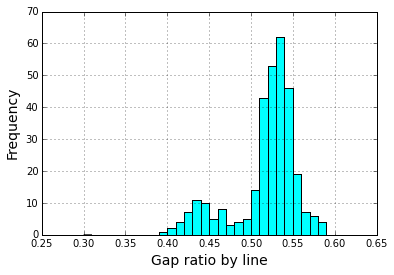

In [30]:
# gap rates for any line, by line
gap_rates = oneday.groupby('Line')['gap_ind'].sum()/oneday.groupby('Line').size()
gap_rates.hist(range=(0.3,0.6),bins=30,color='cyan')
pl.xlabel("Gap ratio by line",fontsize=14)
pl.ylabel("Frequency",fontsize=14)

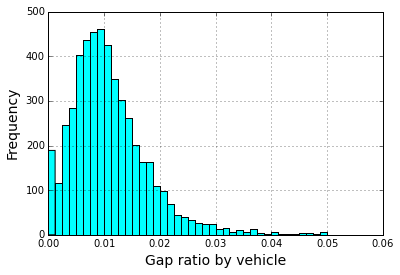

In [31]:
# veh-caused gap rates by vehicle
vehicle_gap_rates = oneday.groupby('vehicleID')['veh_gap_ind'].sum()/oneday.groupby('vehicleID').size()
vehicle_gap_rates.hist(range=(0.0,0.05),bins=40,color='cyan')
pl.xlabel("Gap ratio by vehicle",fontsize=14)
pl.ylabel("Frequency",fontsize=14)

## Plot gap ratio according to time-of-day, to check for time-series correlation
Siri API performance is known to be much better in the middle of the night.

It is unknown whether this is related to server-request load, size of response data, or "throttling" of user requests.

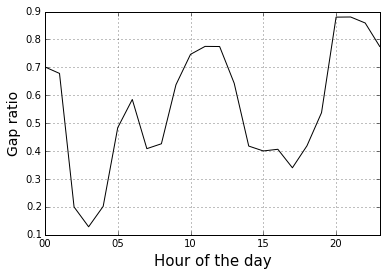

In [34]:
oneday['response_hour'] = oneday.ResponseTimeStamp.str[11:13]
hourly_gap_rates = oneday.groupby('response_hour')['gap_ind'].sum()/oneday.groupby('response_hour').size()
hourly_gap_rates.plot(color='black')
pl.xlabel("Hour of the day",fontsize=14,size=15)
pl.ylabel("Gap ratio",fontsize=14)